#Import Library

In [ ]:
import pandas as pd # dataframes
import numpy as np # algebra & calculus
import nltk # text preprocessing & manipulation
# from textblob import TextBlob
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

from functools import partial # to reduce df memory consumption by applying to_numeric

color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

%matplotlib inline

# Data Collection

##Load data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Put the data in  pandas dataframe

order_products_train = pd.read_csv('/content/gdrive/MyDrive/Biofarma/order_products__train.csv')
order_products_prior = pd.read_csv('/content/gdrive/MyDrive/Biofarma/order_products__prior.csv')
orders = pd.read_csv('/content/gdrive/MyDrive/Biofarma/orders.csv')
products = pd.read_csv('/content/gdrive/MyDrive/Biofarma/products.csv')
aisles = pd.read_csv('/content/gdrive/MyDrive/Biofarma/aisles.csv')
departments = pd.read_csv('/content/gdrive/MyDrive/Biofarma/departments.csv')

#Data cleaning and validation

In [ ]:
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [ ]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [ ]:
departments.isnull().sum()

department_id    0
department       0
dtype: int64

# Data Preparation

## Exploring file

In [ ]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [ ]:
#display first rows.
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
#display first rows. 
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


## Gabung menjadi order_products dataframe

In [ ]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [ ]:
#display first rows.
order_products_all.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Cek missing value pada order_products data frame

In [ ]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
order_id,0,0.0
product_id,0,0.0
add_to_cart_order,0,0.0
reordered,0,0.0


## Check the number of unique orders and unique products

In [ ]:
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


## Gabung file aisles, department, dan products

In [ ]:
# Merging tables together.
products_departments = products.merge(departments, left_on='department_id', right_on='department_id', how='left')
products_departments_aisles = products_departments.merge(aisles, left_on='aisle_id', right_on='aisle_id', how='left')
products_departments_aisles.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [ ]:
# Counting how many items is in each product category. 
products_departments_aisles.groupby('department')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False).head(10)

,department,product_id
17,personal care,6563
20,snacks,6264
16,pantry,5371
3,beverages,4365
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


#1. Tampilkan data 10 produk yang paling banyak dipesan

In [ ]:
product_counts = order_products_all.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop = True)
product_counts = product_counts.merge(products, on = 'product_id', how = 'left')

In [ ]:
product_counts = product_counts.drop(columns=["aisle_id", "department_id"])
product_counts.head(10)

,product_id,frequency,product_name
0,24852,491291,Banana
1,13176,394930,Bag of Organic Bananas
2,21137,275577,Organic Strawberries
3,21903,251705,Organic Baby Spinach
4,47209,220877,Organic Hass Avocado
5,47766,184224,Organic Avocado
6,47626,160792,Large Lemon
7,16797,149445,Strawberries
8,26209,146660,Limes
9,27845,142813,Organic Whole Milk


#2. Tampilkan data 10 produk yang paling jarang dipesan

In [ ]:
product_counts = order_products_all.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=True)[0:100].reset_index(drop = True)
product_counts = product_counts.merge(products, on = 'product_id', how = 'left')

In [ ]:
product_counts = product_counts.drop(columns=["aisle_id", "department_id"])
product_counts.head(10)

,product_id,frequency,product_name
0,36233,1,Water With Electrolytes
1,11254,1,Drink Distinct All Natural Soda Pineapple Coco...
2,43098,1,Buddy Bear Probiotic Orange Flavor Chewable
3,14485,1,Organic Ice Cream Birthday Cake
4,7626,1,Brut Prosecco
5,49540,1,Pure Squeezed Lemonade
6,33097,1,Piquillo & Jalapeno Bruschetta
7,46379,1,Skin Firming Cellulite Gel Cream
8,5255,1,Chardonnay Carneros
9,35890,1,Petite Black Eyed Peas


#3. Tampilkan data daftar 2 pesanan (order) pertama dari user_id=1

In [ ]:
# Merging products_departments_aisles and order_products_total.
df = order_products_all.merge(products_departments_aisles, left_on='product_id', right_on='product_id', how='left')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,0,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,0,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood


In [ ]:
df2 = df.merge(orders, left_on='order_id', right_on='order_id', how='left')
df2.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,produce,fresh vegetables,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,produce,fresh vegetables,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood,112108,train,4,4,10,9.0


# 5. Tampilkan data 25 produk yang terakhir dipesan

In [ ]:
products_departments = products_departments.drop(columns="aisle_id")
products_departments.tail(25)

,product_id,product_name,department_id,department
49663,49664,Lemon Cayenne Drinking Vinegar,21,missing
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,19,snacks
49665,49666,Ginger Snaps Snacking Cookies,19,snacks
49666,49667,Enchilada with Spanish Rice & Beans Meal,1,frozen
49667,49668,Apple Cinnamon Scented Candles,17,household
49668,49669,K Cup Dark Blend,21,missing
49669,49670,Beef Summer Sausage,12,meat seafood
49670,49671,Milk Chocolate Drops,19,snacks
49671,49672,Cafe Mocha K-Cup Packs,7,beverages
49672,49673,Stone Baked Multi Grain Artisan Rolls,1,frozen


In [ ]:
n = df2 % 2 == 0
k = df.where(n, -df)
print(k)

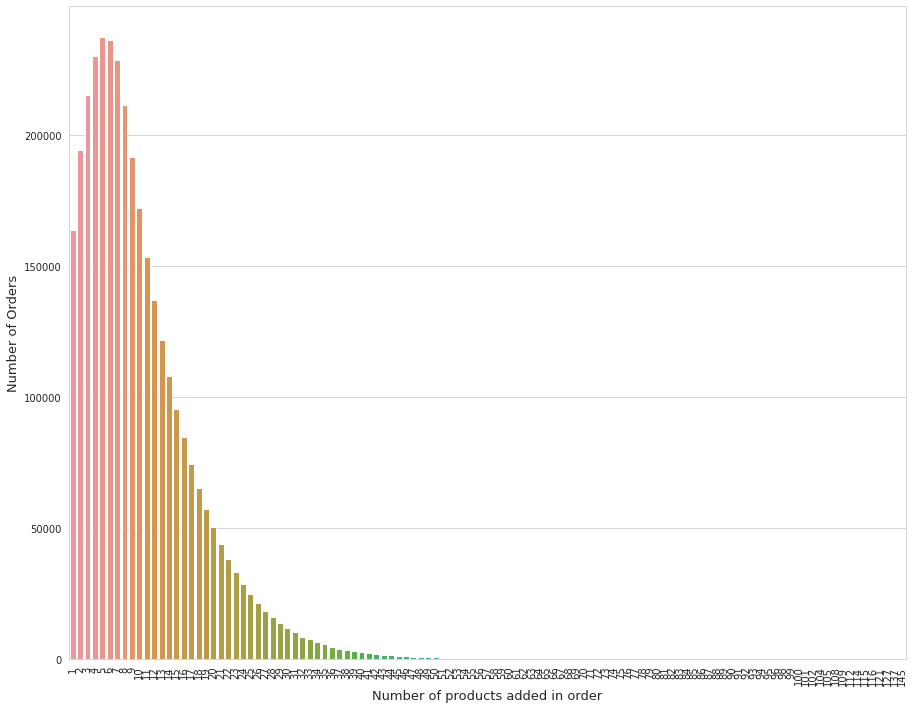

In [ ]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()